<a href="https://colab.research.google.com/github/stuart-lane/Chapter1/blob/main/DefaultDataLogit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ISLP

In [8]:
from ISLP import load_data

import pandas as pd
import numpy as np
import scipy
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
default = load_data("Default")

default['default1'] = (default['default'] == "Yes").astype(int)

<Axes: xlabel='balance', ylabel='income'>

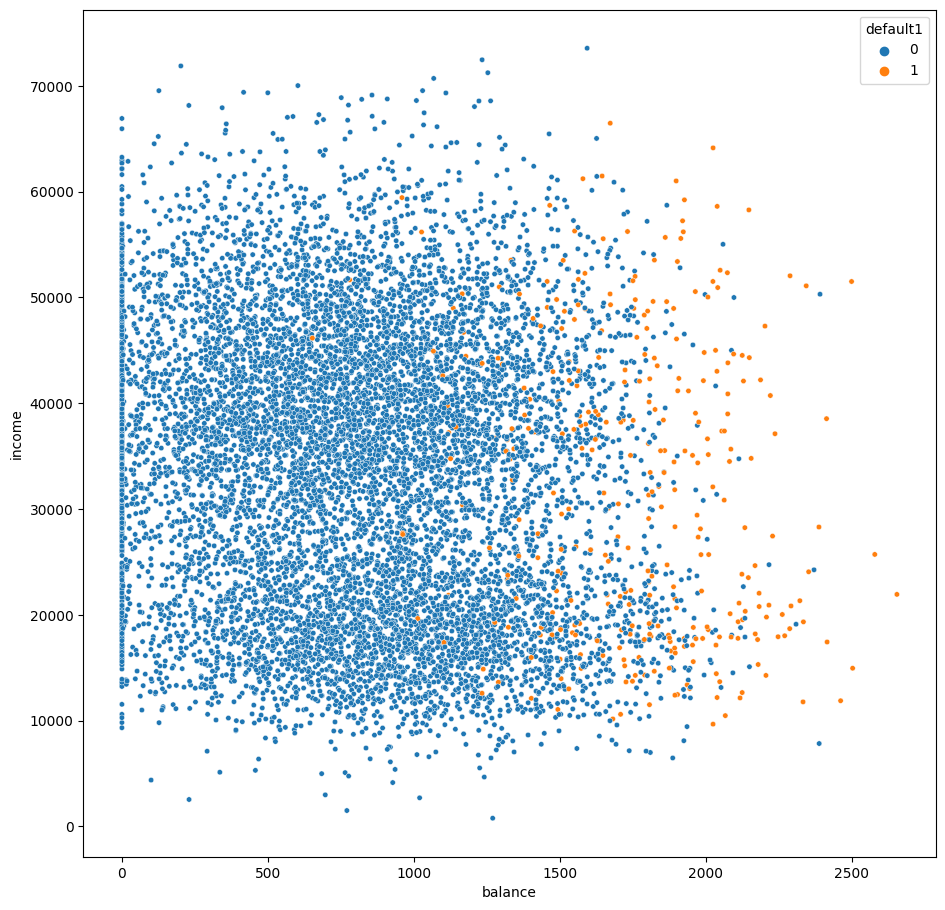

In [4]:
# Scatter plot of income and balance, hued by default

plt.figure(figsize = (11,11))
sns.scatterplot(data = default, x = 'balance', y = 'income', hue = 'default1', s = 15)

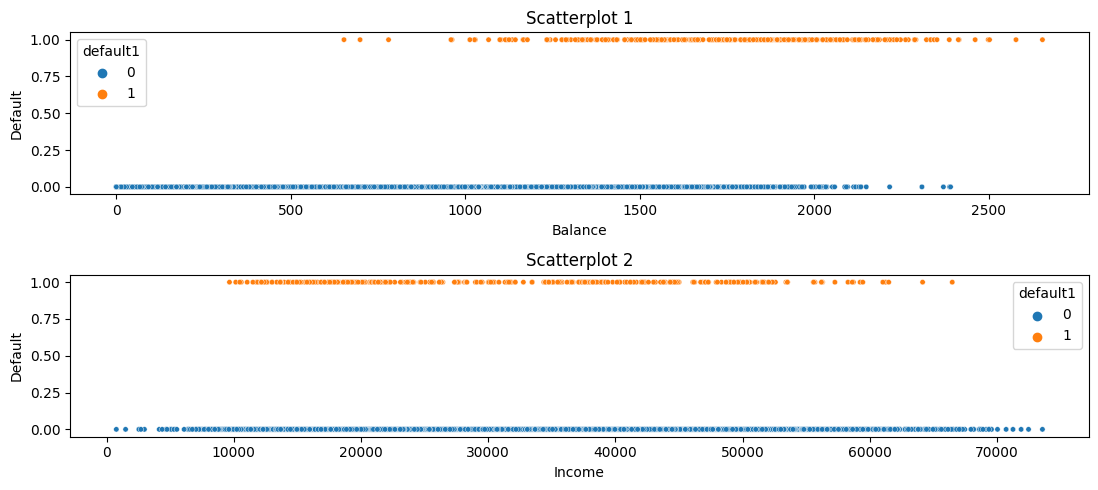

In [5]:
fig, axes = plt.subplots(2, 1, figsize = (11, 5))

sns.scatterplot(data = default, x = 'balance', y = 'default1', hue = 'default1', s = 15, ax = axes[0])
axes[0].set_title('Scatterplot 1')
axes[0].set_xlabel('Balance')
axes[0].set_ylabel('Default')

sns.scatterplot(data = default, x = 'income', y = 'default1', hue = 'default1', s = 15, ax = axes[1])
axes[1].set_title('Scatterplot 2')
axes[1].set_xlabel('Income')
axes[1].set_ylabel('Default')

plt.tight_layout()
plt.show()

## Maximum Likelihood Estimation
### Logistic Regression

Given predictors $x_i$, the posterior probability for class 1 is modeled using the logistic function:

$$ P_{\beta}(y_i = 1 | x_i) = \frac{e^{x_i' \beta}}{1 + e^{x_i' \beta}} =  \frac{1}{1 + e^{-x_i' \beta}}  $$

For a given observation $i$, if $y_i = 1$, then the contribution to the likelihood is $P_{\beta}(y_i = 1 | x_i)$. If $y_i = 0$, then the contribution is $1 - P_{\beta}(y_i = 1 | x_i)$.

This can be represented compactly as:

$$ L_i(\beta) = P_{\beta}(y_i = 1 | x_i)^{y_i} (1 - P_{\beta}(y_i = 1 | x_i))^{1-y_i} $$

### Likelihood Function

Given the data $(Y, x)$, the likelihood for the observed sample is the product of the individual likelihoods:

$$ L(\beta) = \prod_{i = 1}^n P_{\beta}(y_i = 1 | x_i)^{y_i} (1 - P_{\beta}(y_i = 1 | x_i))^{1- y_i} $$

### Log-Likelihood Function

Taking the natural logarithm, we obtain the log-likelihood:

$$ \log L(\beta) = \sum_i \left[ y_i \log P_{\beta}(y_i = 1 | x_i) + (1-y_i) \log (1 - P_{\beta}(y_i = 1 | x_i)) \right]. $$

### Derivative of LL (for Newton optimiser)


The log-likelihood function for logistic regression is given by:
$$
\log L(\beta) = \sum_i \left[ y_i \log P_{\beta}(y_i = 1 | \mathbf{x}_i) + (1-y_i) \log (1 - P_{\beta}(y_i = 1 | \mathbf{x}_i)) \right].
$$

The logistic function $ P_{\beta}(y_i = 1 | \mathbf{x}_i) $ is defined as:
$$
P_{\beta}(y_i = 1 | \mathbf{x}_i) = \frac{1}{1 + e^{-\mathbf{x}_i' \beta}}.
$$

**Step 1:** Compute the derivative of $P_{\beta}(y_i = 1 | \mathbf{x}_i) $ with respect to $\beta $
$$
\frac{\partial P_{\beta}}{\partial \beta} = \frac{e^{-\mathbf{x}_i' \beta} \times (-\mathbf{x}_i)}{(1 + e^{-\mathbf{x}_i' \beta})^2} = P_{\beta}(1 - P_{\beta}) \mathbf{x}_i.
$$

**Step 2:** Compute the derivative of the log-likelihood function with respect to $ \beta $.
We differentiate the $i$-th term in the summation with respect to $\beta$:
$$
\frac{\partial}{\partial \beta} \left( y_i \log P_{\beta} + (1-y_i) \log (1 - P_{\beta}) \right) = y_i \frac{1}{P_{\beta}} \frac{\partial P_{\beta}}{\partial \beta} + (1-y_i) \frac{-1}{1-P_{\beta}} \frac{\partial P_{\beta}}{\partial \beta}.
$$
Using the derivative from Step 1, this simplifies to:
$$
= y_i \frac{\mathbf{x}_i}{P_{\beta}} P_{\beta}(1 - P_{\beta}) - (1-y_i) \frac{\mathbf{x}_i}{1 - P_{\beta}} P_{\beta}(1 - P_{\beta}).
$$
Further simplification yields:
$$
= \mathbf{x}_i(y_i - P_{\beta}).
$$
**Step 3:** Sum over all \( i \) to get the gradient for the entire sample:
$$
\frac{\partial \log L(\beta)}{\partial \beta} = \sum_i \mathbf{x}_i (y_i - P_{\beta}(y_i = 1 | \mathbf{x}_i)).
$$

### Bayes Classifier
$$ \widehat{Y}_i = \mathbf{1}\left\{P_{\widehat{\beta}}(y_i = 1 | x_i)  \geq \frac{1}{2}\right\}$$

Dataset

In [10]:
from sklearn.model_selection import train_test_split

x = default[['balance', 'income']].values
x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)
beta_initial = np.array([0, 0, 0])

In [13]:
def logistic(x, beta):
    x_beta = np.dot(x, beta)
    x_beta = np.clip(x_beta, -500, 500)
    return 1 / (1 + np.exp(-x_beta))

def log_likelihood(beta, x, y):
    p = logistic(x, beta)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    return -ll

# Example data (replace with your data)
beta_initial = np.array([0, 0, 0])

# Minimize the negative log-likelihood to estimate parameters
from scipy.optimize import minimize
result = minimize(log_likelihood, beta_initial, args=(x_train, y_train), method='BFGS')

# Extract the estimated parameters
estimated_beta = [f'{param:.7f}' for param in result.x]
formatted_parameters = ', '.join(estimated_beta)

print(f"Estimated Parameters: [{formatted_parameters}]")
print("Negative Log-Likelihood:", result.fun)

Estimated Parameters: [-11.3253654, 0.0055048, 0.0000215]
Negative Log-Likelihood: 647.4488523646728


In [14]:
bhat = [float(bk) for bk in estimated_beta]

[(8000,), (8000,)]


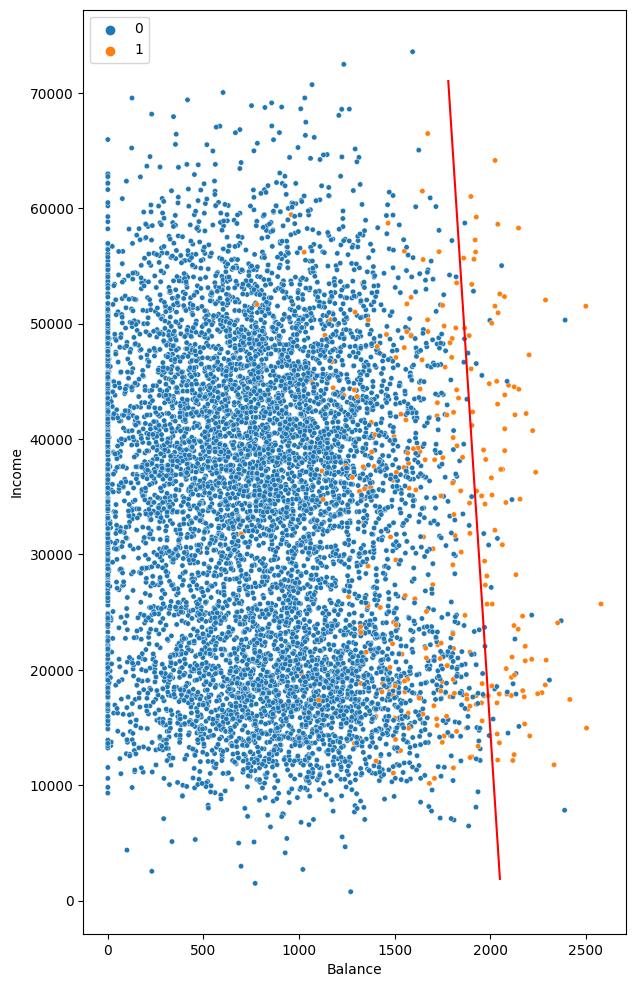

In [23]:
# Bayes decision boundary (BDB)
slope = -bhat[1]/bhat[2]
intercept = -bhat[0]/bhat[2]
x_grid = np.linspace(1780, 2050, 8000)
yhat = logistic(x_train, result.x)
bdb = [slope * xi + intercept for xi in x_grid]
bdb_array = np.array(bdb)
print([y_train.shape, bdb_array.shape])
df2 = {'balance': x_train[:,1], 'income': x_train[:,2], 'default': y_train, 'est_probs': yhat, 'bdb': bdb_array}
df2 = pd.DataFrame(df2)
df2 = pd.concat([df2, pd.DataFrame({'x_grid': x_grid})], axis = 1)

plt.figure(figsize = (7, 12))
sns.scatterplot(data = df2, x = 'balance', y = 'income', s = 15, hue = 'default')
# sns.lineplot(data = df2, x = 'balance', y = 'bdb', color = 'red')
sns.lineplot(data = df2, x = 'x_grid', y = 'bdb', color = 'red')

# Add labels and legend
plt.xlabel('Balance')
plt.ylabel('Income')
plt.legend(loc='upper left')

# Show the plot
plt.show()